### パッケージの追加

In [2]:
using Pkg
Pkg.add("StaticArrays")
Pkg.add("LinearAlgebra")
Pkg.add("Combinatorics")
Pkg.add("Ripserer")
Pkg.add("Plots")
Pkg.add("Random")
Pkg.add("MultivariateStats")
Pkg.add("PersistenceDiagrams")


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Ch

### 使用するライブラリの宣言

In [3]:
using StaticArrays
using LinearAlgebra
using Combinatorics
using Ripserer
using Plots
using Random
using MultivariateStats
using PersistenceDiagrams
sa = StaticArrays
la = LinearAlgebra
cm = Combinatorics 

Combinatorics

In [4]:

function ArgPowertoInt(number::Float64)::Int64
    n::Int64 = 0
    while number*(10^n) - Int64(floor(number*(10^n))) !== 0.0
        n += 1
    end
    return n
end
#f:R -> [0, 1)

#f:[0, 1] -> [-1, 1]

ArgPowertoInt (generic function with 1 method)

In [5]:
function FloatToInt(number::Float64)::Int64
    n::Int64 = ArgPowertoInt(number)
    if n === 0
        return Int64(floor(number))
    else
        if number < 0.0
            return Int64(floor(number)) + 1
        else
            return Int64(floor(number))
        end
    end
end

function Fractional(number::Float64)::Float64
    n::Int64 = ArgPowertoInt(number)
    (number*10^n - FloatToInt(number)*10^n)/10^n
end


Fractional (generic function with 1 method)

In [6]:
SPoint = sa.SVector{2, Float64}
SamePoints = Tuple{SPoint, SPoint, SPoint, SPoint}
Point = @sa.SVector [-1.0, -0.2]

function Scale(x::Float64; range_min::Float64=0.0, range_max::Float64=1.0)
    x_frac::Float64 = Fractional((x - 1.0) * (range_max - range_min)) + Fractional(range_max)
    x_int::Int64 = FloatToInt((x - 1.0) * (range_max - range_min)) +FloatToInt(range_max)
    return x_frac + x_int
end
#f:[-1, 1] * [-1, 1] -> [a,b]*[c, d]
function ScaleSquare(Point::SPoint; x_range_min = -1.0, x_range_max = 1.0, y_range_min= -1.0, y_range_max = 1.0)
    x_frac::Float64 = Fractional((Point.x - 1.0) * (x_range_max - x_range_min)/2.0) + Fractional(x_range_max)
    x_int::Int64 = FloatToInt((Point.x - 1.0) * (x_range_max - x_range_min)/2.0) +FloatToInt(x_range_max)
    y_frac::Float64 =  Fractional((Point.y - 1.0) * (y_range_max - y_range_min)/2.0) +  Fractional(y_range_max)
    y_int::Int64 = FloatToInt((Point.y - 1.0) * (y_range_max - y_range_min)/2.0) + FloatToInt(y_range_max)
    return @sa.SVector [x_int + x_frac, y_int + y_frac]
end

function ScaleSquare_Func(;x_range_min = -1.0, x_range_max = 1.0, y_range_min= -1, y_range_max = 1.0)
    return (Point) -> ScaleSquare(Point; x_range_min = x_range_min, x_range_max = x_range_max, y_range_min= y_range_min, y_range_max = y_range_max)
end

ScaleSquare_Func (generic function with 1 method)

In [7]:
Scale(0.3, range_min = -1.0)

-0.4

In [8]:
f = ScaleSquare_Func()
f(Point)

2-element SVector{2, Float64} with indices SOneTo(2):
 -1.0
 -0.2

### Klein bottle の距離の計算のための関数の定義

In [9]:

function first_in_klein(point::SPoint)::SPoint
    x::Float64 = point[1]
    y::Float64 = point[2]
    if (0 <= x <= 1) & (0 <= y <= 1)
        return point

    elseif -1 <= x < 0 < y <= 1
        return @sa.SVector [x + 2.0, 2.0 - y]

    elseif (-1 <= x < 0) & (-1 <= y <= 0)
        return @sa.SVector [x + 2.0, -y]

    elseif (-1 <= y < 0 <= x <=1)
        return @sa.SVector [x, 2.0 + y]
    end
    throw(DomainError(point, "Make sure that the first and second coordinates are in the intreval [-1, 1]"))
end

function samepoints_in_kelin(point:: SPoint)::SamePoints
    firstpoint:: SPoint = first_in_klein(point)
    x:: Float64 = firstpoint[1]
    y:: Float64 = firstpoint[2]
    second:: SPoint = @sa.SVector [x - 2.0, 2.0 - y]
    theard:: SPoint = @sa.SVector [x - 2.0, -y]
    fourth:: SPoint =  @sa.SVector [x, y - 2.0]
    return (firstpoint, second, theard, fourth)
end


samepoints_in_kelin (generic function with 1 method)

In [10]:
Quadrants = Tuple{Int64, Int64}
function quadrants_square_distance(quadrants:: Quadrants, samepoints1:: SamePoints, samepoints2:: SamePoints)::Float64
    index1:: Int64 = quadrants[1]
    index2:: Int64 = quadrants[2]
    diff:: SPoint = samepoints1[index1]- samepoints2[index2]
    return la.norm(diff)
end

function candidates_quadrants(point1:: SPoint, point2:: SPoint)::Tuple{Quadrants, Quadrants}
    add_second:: Float64 = (point1 + point2)[2]
    diff:: SPoint = point1 - point2
    #print(diff[2], 'in candidate_quadrants')
    #candidate1:: Quadrants = (1, 3) if (add_second < 1.0)  else (1, 2) if (add_second < 3.0) else (4, 2)
    candidate1:: Quadrants = add_second < 1.0 ? (1, 3) : add_second < 3.0 ? (1, 2) : (4, 2)
    candidate2:: Quadrants =  diff[2] < -1.0 ? (1, 4) : diff[2] < 1.0 ? (1, 1) : (2, 3)
    return (diff[1] >= 0 ? reverse(candidate1) : candidate1, candidate2)
end


candidates_quadrants (generic function with 1 method)

### 多様体ごとの距離関数の定義

In [11]:
#距離関数の定義

#Circle 
# function Distance_in_Circle(data_1::Float64, data_2::Float64)::Float64
#     tmp_1 = Fractional(data_1)
#     tmp_2 = Fractional(data_2)
#     diff::Float64 = round(abs(tmp_1 - tmp_2)*(10^15))/(10^15)
#     return min(diff, 1.0 - diff)
# end

function Distance_in_Circle(data_1::Float64, data_2::Float64;range_min::Float64 = 0.0, range_max::Float64 = 1.0)::Float64
    data_1 = Scale(data_1;range_min=range_min, range_max=range_max)
    data_2 = Scale(data_2;range_min=range_min, range_max=range_max)
    return 1 - cos(2 *pi * (data_1 - data_2) / (range_max - range_min))
end

#Torus
function Distance_in_Torus(point1::SPoint, point2::SPoint;x_range_min::Float64 = -1.0, x_range_max::Float64 = 1.0, y_range_min::Float64 = -1.0, y_range_max::Float64 = 1.0)::Float64
    dist = Distance_in_Circle(point1[1], point2[1];range_min=x_range_min, range_max=x_range_max) + Distance_in_Circle(point1[2], point2[2];range_min=y_range_min, range_max=y_range_max)
    sqrt(dist)
end


   
#RealProjection
function Distance_in_RealProjection(data_1::Float64, data_2:: Float64)::Float64
    Distance_in_Circle(2 * data_1, 2 * data_2)
end

#Klein Bottle
function distance_in_klein_bottle(point1:: SPoint, point2:: SPoint; )::Float64
    samepoints1:: SamePoints = samepoints_in_kelin(point1)
    samepoints2:: SamePoints = samepoints_in_kelin(point2)
    if samepoints1 === samepoints2
        return 0.0
    end
    point1_in_first:: SPoint = samepoints1[1]
    point2_in_first:: SPoint = samepoints2[1]
    candidates:: Tuple{Quadrants, Quadrants} = candidates_quadrants(point1_in_first, point2_in_first)
    #print(candidates, 'in dist klein')
    dist1:: Float64 = quadrants_square_distance(candidates[1], samepoints1, samepoints2)
    dist2:: Float64 = quadrants_square_distance(candidates[2], samepoints1, samepoints2)
    #print(dist1, dist2)
    distance:: Float64 = minimum((dist1, dist2))
end
    

distance_in_klein_bottle (generic function with 1 method)

### 距離行列の計算

In [12]:
function matrix_index(;matrix_size::Tuple{Int64, Int64}, index::Int64):: Tuple{Int64, Int64}
    row:: Int64 = matrix_size[1]
    column:: Int64 = matrix_size[2]
    remainder:: Int64 = rem(index, row)
    division:: Int64 = div(index, row)
    if index > row * column
        throw(DomainError(index, "Make sure that index <= row * column"))
    end

    return remainder !== 0 ? (remainder, division + 1) : (row, division)
    
end

function matrix_index(indexies:: Tuple{Int64, Int64};matrix_size::Tuple{Int64, Int64}):: Int64
    i:: Int64, j:: Int64 = indexies
    row:: Int64, column:: Int64 = matrix_size
    index:: Int64 = (j - 1) * row + i
    if (i > row) || (j > column)
        throw(DomainError(index, "Make sure that each index <= row , column"))
    end
    return index
end

function distance_matrix(pointcloud:: Vector{SPoint},  distance::Function):: Array{Float64, 2}
    point_num:: Int64 = size(pointcloud, 1)
    indexcombs::Base.Generator{Combinatorics.Combinations,Combinatorics.var"#10#13"{Combinatorics.var"#reorder#11"{UnitRange{Int64}}}} = cm.combinations(1:point_num, 2)
    dist_matrix:: Array{Float64, 2} = zeros(point_num, point_num)
    for indexies = indexcombs
        i::Int64, j:: Int64 = reverse(Tuple(indexies))
        dist_matrix[matrix_index((i, j), matrix_size=(point_num, point_num))] = distance(pointcloud[i], pointcloud[j])
    end
    #return map(points:: Vector{SPoint}-> distance_in_klein_bottle(points[1], points[2])::Float64, combs)
    return dist_matrix + transpose(dist_matrix)
end

function distance_matrix(pointcloud:: Matrix{Float64},  distance::Function):: Array{Float64, 2}
    point_num:: Int64 = size(pointcloud, 1)
    indexcombs::Base.Generator{Combinatorics.Combinations,Combinatorics.var"#10#13"{Combinatorics.var"#reorder#11"{UnitRange{Int64}}}} = cm.combinations(1:point_num, 2)
    dist_matrix:: Array{Float64, 2} = zeros(point_num, point_num)
    for indexies = indexcombs
        i::Int64, j:: Int64 = reverse(Tuple(indexies))
        dist_matrix[matrix_index((i, j), matrix_size=(point_num, point_num))] = distance(pointcloud[i], pointcloud[j])
    end
    #return map(points:: Vector{SPoint}-> distance_in_klein_bottle(points[1], points[2])::Float64, combs)
    return dist_matrix + transpose(dist_matrix)
end



distance_matrix (generic function with 2 methods)

### (コ)ホモロジーの計算

In [13]:

function CreateRipsPCohomology(;pointcloud::Vector{SPoint},distance::Function, max_dim::Int = 2, reps::Bool = true)
    distmat = distance_matrix(pointcloud, distance)
    klein_vrip_fill = Rips(distmat; threshold=nothing)
    return ripserer(klein_vrip_fill; dim_max=max_dim, reps=reps)
end


CreateRipsPCohomology (generic function with 1 method)

### 乱数生成

In [14]:
function staticalize(ndarray:: Array{Float64, 2})::Vector{SPoint}
    rownum ::Int = size(ndarray, 1)
    return [SPoint(ndarray[i,:]) for i = 1:rownum]
end

function uniformpoints_in_square(;range_min:: Float64, range_max:: Float64, sampling:: Int64, step:: Float64 = 0.00001)::Array{Float64,}
    rng = range_min:step:range_max
    dim:: Int64 = 2
    return rand(rng, (sampling, dim))
end

rng = MersenneTwister(0)
function randn_poitns(;num_point:: Int64, dim:: Int64=2, normalize::Bool = true)::Array{Float64, 2}
    randompoints = randn(rng, (num_point, dim))
    if normalize
        max_range = maximum(map(point -> norm(point), randompoints))
        randompoints = randompoints / max_range
    end
    
    return randompoints
end

randn_poitns (generic function with 1 method)

### サイクルのプロット

In [58]:
function plotting_cycle(;pointcloud::Vector{SPoint}, cohomology, num::Int64,timerate,legend=nothing)
    filtration = cohomology[2].filtration
    cycles =[]
    for i = 0:num-1
        persistent_co = cohomology[2][end - i]
        time = (death(persistent_co) - birth(persistent_co))*timerate + birth(persistent_co)
        reconstructed_at_time = reconstruct_cycle(filtration, persistent_co,time)
        println(reconstructed_at_time)
        push!(cycles, reconstructed_at_time)
    end
    common_cycle = cycles[1]
    for cycle = cycles
        common_cycle = intersect(common_cycle, cycle)
    end
    x = [point[1] for point = pointcloud]
    y = [point[2] for point = pointcloud]
    scatter(x,y; label="data", markersize=2, legend = legend)
    i = 0
    for cycle = cycles
        if num > 1
            colorRate = 1 - i / (num - 1)
        else
            colorRate = 1
        end
        plot!(cycle, x, y; label="$i th -most persistent", color=RGBA(1- colorRate, 0, colorRate))
        i +=1
    end
    if !isempty(common_cycle)
        plot!(common_cycle, x, y; label="intersect", color="green")
    end
    plot!(title="Interval ratio = $timerate")
end

plotting_cycle (generic function with 1 method)

### 一様乱数によるサンプリング

In [37]:
pointcloud = uniformpoints_in_square(range_min=-1.0, range_max=1.0, sampling=500)
staticpointcloud = staticalize(pointcloud)

500-element Vector{SVector{2, Float64}}:
 [-0.9865, -0.23163]
 [0.4693, 0.44073]
 [0.83283, -0.76507]
 [-0.629, -0.85006]
 [0.24148, -0.71648]
 [-0.2162, 0.33266]
 [0.5997, -0.79239]
 [0.89695, 0.97198]
 [0.27285, 0.51706]
 [-0.20631, 0.0071]
 [-0.08955, 0.33726]
 [-0.89922, 0.70112]
 [-0.96891, -0.8132]
 ⋮
 [-0.99305, -0.39176]
 [-0.69472, 0.25077]
 [-0.5106, 0.13463]
 [-0.1742, -0.81996]
 [0.15613, 0.20377]
 [-0.78071, -0.03174]
 [-0.24898, 0.85719]
 [-0.87728, -0.11881]
 [0.67872, 0.17732]
 [-0.41945, 0.06363]
 [-0.85971, -0.11314]
 [-0.66903, -0.87668]

### Klein Bottle距離でのホモロジーの計算

In [17]:
distmat = distance_matrix(staticpointcloud, distance_in_klein_bottle)

500×500 Matrix{Float64}:
 0.0       0.437361  0.822384  0.964409  …  1.10491   0.842254  0.397039
 0.437361  0.0       0.932294  0.847908     0.794649  0.989999  0.786616
 0.822384  0.932294  0.0       0.594197     0.910442  1.19483   0.649411
 0.964409  0.847908  0.594197  0.0          0.911611  0.656358  1.16024
 0.958574  0.640256  0.943439  0.954145     0.7833    0.619403  0.577567
 0.758708  1.02145   0.518823  0.864753  …  0.819437  0.862694  0.381853
 1.14658   1.00023   0.87835   0.388459     0.631507  0.321164  0.995827
 0.470898  0.601025  0.360424  0.953986     0.853366  1.09869   0.427066
 0.890902  0.87178   0.467295  0.202915     1.06265   0.857451  1.09103
 0.829069  0.694831  0.47195   0.924238     0.442027  1.02962   0.88144
 0.515301  0.399672  0.928395  0.475565  …  1.17689   0.83935   0.909093
 0.608342  0.845795  0.715732  0.689221     0.736459  0.753483  0.84273
 0.51194   0.669022  0.310598  0.899939     0.896767  1.08549   0.409754
 ⋮                            

In [38]:
klein_vrips_co = CreateRipsPCohomology(pointcloud=staticpointcloud, distance=distance_in_klein_bottle,max_dim=2, reps = true)

3-element Vector{PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 129-element 1-dimensional PersistenceDiagram
 108-element 2-dimensional PersistenceDiagram

In [39]:
torus_vrips_co = CreateRipsPCohomology(pointcloud=staticpointcloud, distance=Distance_in_Torus, max_dim=2, reps=true)

3-element Vector{PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 146-element 1-dimensional PersistenceDiagram
 130-element 2-dimensional PersistenceDiagram

### ユークリッド距離との比較

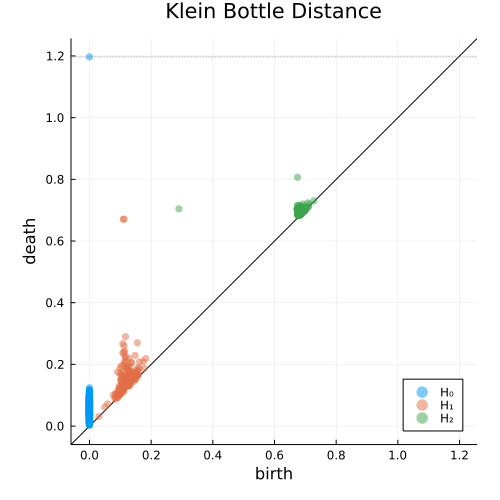

In [40]:
plot(klein_vrips_co; title="Klein Bottle Distance", size =(500, 500))

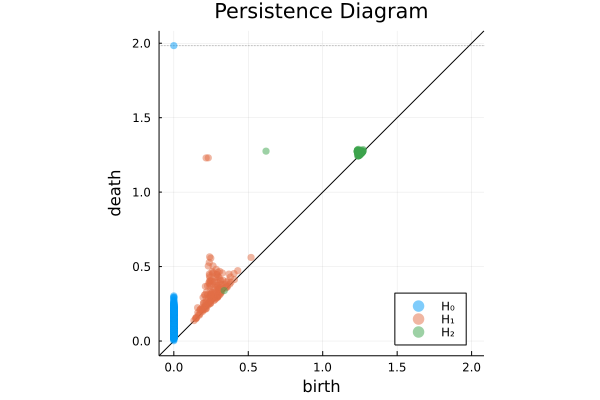

In [41]:
plot(torus_vrips_co)

In [42]:
function filteredDgms(;dgms::Vector{PersistenceDiagram}, epsilon::Float64)
    [PersistenceDiagram(filter(intreval -> persistence(intreval) > epsilon, dgms[i]); dim = i - 1) for i = 1:3]
end

filteredDgms (generic function with 1 method)

In [45]:
filtered_klein = filteredDgms(dgms = klein_vrips_co, epsilon = 0.1)

3-element Vector{PersistenceDiagram}:
 27-element 0-dimensional PersistenceDiagram
 11-element 1-dimensional PersistenceDiagram
 2-element 2-dimensional PersistenceDiagram

In [46]:
barcode(dgms, title="Klein Bottle Distance")

In [47]:
filtered_torus = filteredDgms(dgms =torus_vrips_co, epsilon = 0.2)

3-element Vector{PersistenceDiagram}:
 68-element 0-dimensional PersistenceDiagram
 9-element 1-dimensional PersistenceDiagram
 1-element 2-dimensional PersistenceDiagram

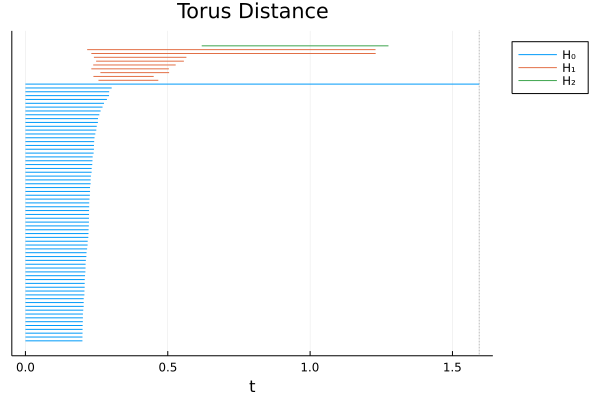

In [48]:
barcode(filtered_torus, title = "Torus Distance")

### サイクルの表示

In [49]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=klein_vrips_co,num = 2, timerate = 0.0,legend=:top)

Simplex{1, Float64, Int64}[+Simplex{1}((269, 159), 0.42820838665304073), +Simplex{1}((386, 269), 0.3642396400723017), +Simplex{1}((386, 252), 0.4855378128426252), +Simplex{1}((252, 26), 0.23254223702372864), +Simplex{1}((159, 26), 0.4896409554969846)]
Simplex{1, Float64, Int64}[+Simplex{1}((269, 159), 0.42820838665304073), +Simplex{1}((386, 269), 0.3642396400723017), +Simplex{1}((386, 252), 0.4855378128426252), +Simplex{1}((252, 26), 0.23254223702372864), +Simplex{1}((159, 26), 0.4896409554969846)]


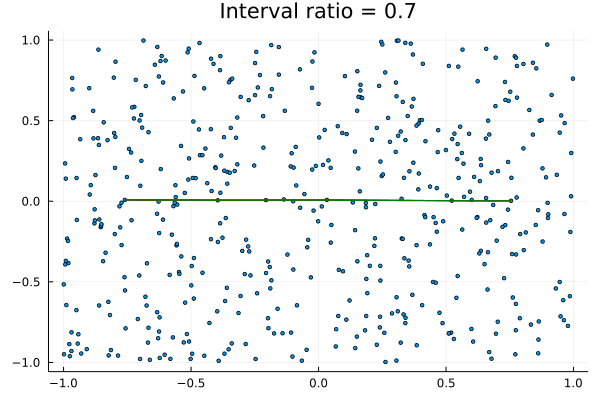

In [59]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=klein_vrips_co,num = 2, timerate = 0.7,legend=nothing)

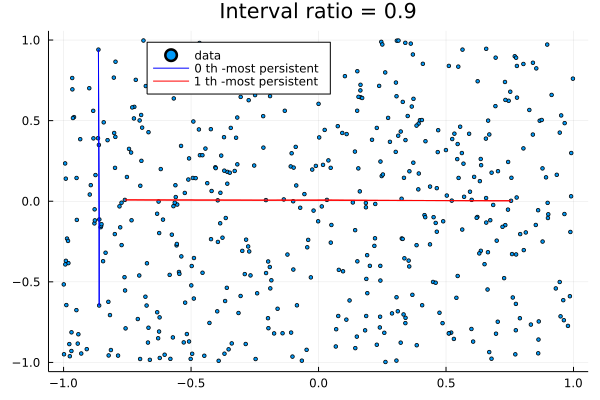

In [51]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=klein_vrips_co,num = 2, timerate = 0.9,legend=:top)

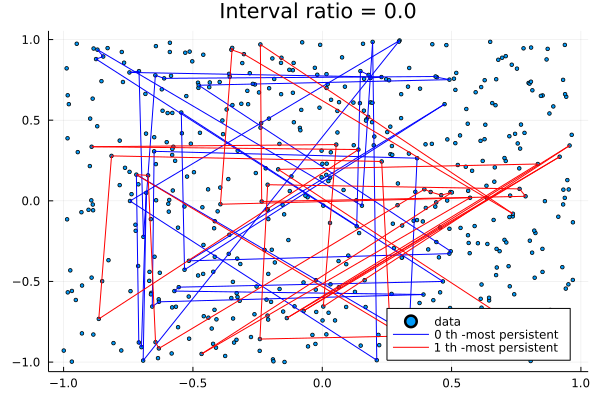

In [31]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=torus_vrips_co, num = 2, timerate = 0.0, legend =:bottomright)

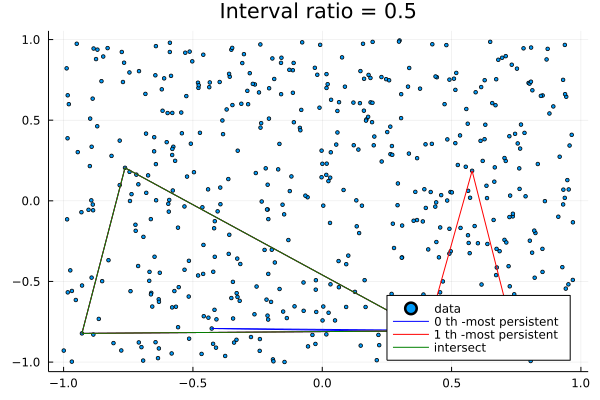

In [32]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=torus_vrips_co, num = 2, timerate = 0.5, legend =:bottomright)

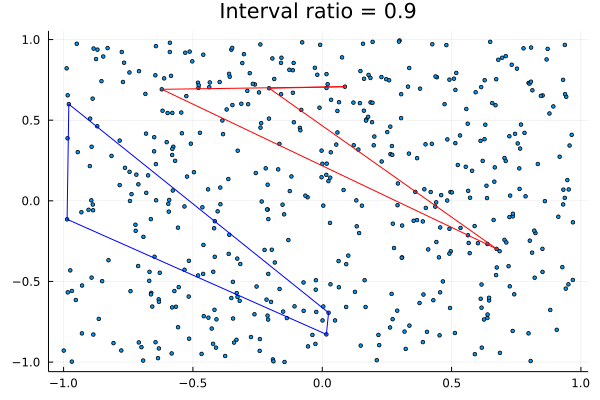

In [33]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=torus_vrips_co, num = 2, timerate = 0.9, legend = nothing)

### 正規乱数の場合

In [60]:
variance_1 = 0.5
variance_2 = 0.3
d_1 = truncated(Normal(0.0, variance_1); lower=-1.0, upper= 1.0)
d_2 = truncated(Normal(0.0, variance_2); lower=-1.0, upper=1.0)

Truncated(Normal{Float64}(μ=0.0, σ=0.3); lower=-1.0, upper=1.0)

In [61]:
pointcloud = [ @sa.SVector[t[1], t[2]]  for t = zip(rand(d_1, 500),rand(d_2, 500))]

500-element Vector{SVector{2, Float64}}:
 [-0.30877209989497056, 0.40195321913253523]
 [-0.3347084829564074, 0.14706687838202456]
 [-0.06626341700202791, 0.0348805645995475]
 [0.32678845057749756, 0.06004563610444254]
 [0.571328075791353, -0.1334450118624778]
 [-0.08311007366502632, 0.1174391074713844]
 [0.2746994763839935, -0.6551136926035045]
 [-0.5891063289026137, -0.05884858622039905]
 [0.4628396502878412, -0.36604135325832515]
 [0.3956500484590618, -0.013524110696908074]
 [-0.5645459696231647, 0.2482207662199263]
 [0.5813968848431768, -0.6967259012158253]
 [-0.0011213392949254734, -0.08302592839323729]
 ⋮
 [0.7680546974495939, -0.45142610599547217]
 [0.043301003603365286, 0.2368590641709576]
 [0.7894805429622913, -0.058508997979233444]
 [-0.27375239244487193, 0.413271215692415]
 [-0.1595254284870766, 0.09958562501498368]
 [0.11582257851927842, 0.11120200055596223]
 [-0.12935350870588452, -0.31125476320271056]
 [0.5305720469207676, 0.012691322024202086]
 [-0.45787080671482244, -0.3

In [62]:
klein_vrips_normal = CreateRipsPCohomology(pointcloud=pointcloud, distance=distance_in_klein_bottle, max_dim=2, reps=true)

3-element Vector{PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 127-element 1-dimensional PersistenceDiagram
 39-element 2-dimensional PersistenceDiagram

In [63]:
barcode(klein_vrips_normal)

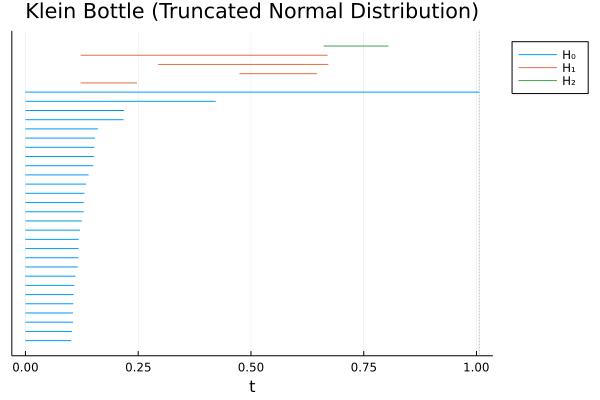

In [82]:
filtered_klein = filteredDgms(dgms = klein_vrips_normal, epsilon = 0.1)
barcode(filtered_klein, title="Klein Bottle (Truncated Normal Distribution)")

Simplex{1, Float64, Int64}[+Simplex{1}((374, 305), 0.12230432956339672), +Simplex{1}((374, 58), 0.11829403905672006), +Simplex{1}((59, 58), 0.10690181789134087), +Simplex{1}((168, 59), 0.05438669113510004), +Simplex{1}((292, 168), 0.10737717991892785), +Simplex{1}((292, 11), 0.10037009732183338), +Simplex{1}((266, 11), 0.07851547458057732), +Simplex{1}((485, 266), 0.07765702850005744), +Simplex{1}((485, 310), 0.09534567983083744), +Simplex{1}((310, 68), 0.10192254637366828), +Simplex{1}((97, 68), 0.09879842367486473), +Simplex{1}((97, 6), 0.05109556296739078), +Simplex{1}((449, 6), 0.08498140568785102), +Simplex{1}((449, 114), 0.09908433479968062), +Simplex{1}((121, 114), 0.031547586435945914), +Simplex{1}((239, 121), 0.12024605726930017), +Simplex{1}((239, 115), 0.10828230631214768), +Simplex{1}((457, 115), 0.07588799288574195), +Simplex{1}((457, 313), 0.05875284365329242), +Simplex{1}((313, 20), 0.0735210000591287), +Simplex{1}((82, 20), 0.1021099315675363), +Simplex{1}((422, 82), 0.

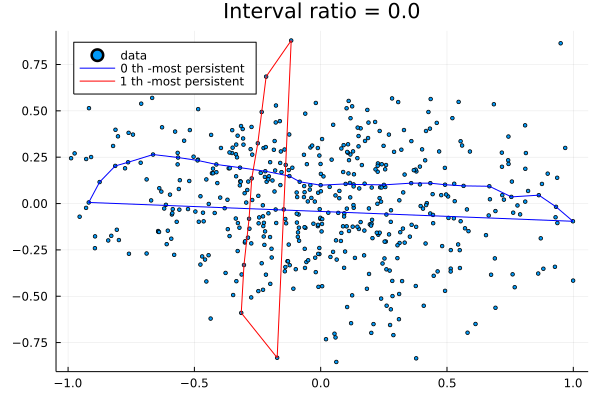

In [65]:
plotting_cycle(;pointcloud=pointcloud, cohomology=klein_vrips_normal,num = 2, timerate=0.0, legend=:topleft)

Simplex{1, Float64, Int64}[+Simplex{1}((374, 341), 0.302693219976117), +Simplex{1}((374, 148), 0.3059498328282967), +Simplex{1}((431, 148), 0.3836478903421225), +Simplex{1}((458, 431), 0.35877448320751776), +Simplex{1}((458, 299), 0.28758156215852315), +Simplex{1}((341, 299), 0.36166744768407666)]
Simplex{1, Float64, Int64}[+Simplex{1}((443, 370), 0.29413055466613575), +Simplex{1}((443, 193), 0.467322993983145), +Simplex{1}((193, 96), 0.333815261642098), +Simplex{1}((465, 96), 0.4764156216987909), +Simplex{1}((465, 370), 0.43719738384181805)]


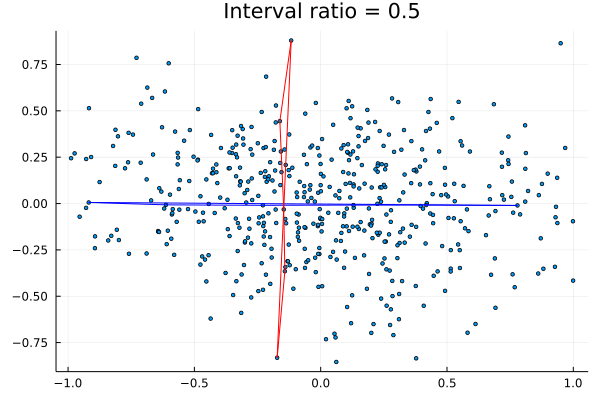

In [66]:
plotting_cycle(;pointcloud=pointcloud, cohomology=klein_vrips_normal,num = 2, timerate=0.5)

Simplex{1, Float64, Int64}[+Simplex{1}((374, 341), 0.302693219976117), +Simplex{1}((374, 118), 0.47525220982771127), +Simplex{1}((458, 118), 0.5729430594411724), +Simplex{1}((458, 299), 0.28758156215852315), +Simplex{1}((341, 299), 0.36166744768407666)]
Simplex{1, Float64, Int64}[+Simplex{1}((229, 179), 0.6330159509772775), +Simplex{1}((390, 229), 0.34389673015157624), +Simplex{1}((390, 98), 0.3720327894217678), +Simplex{1}((270, 98), 0.5208935152627311), +Simplex{1}((270, 179), 0.13231710802376515)]


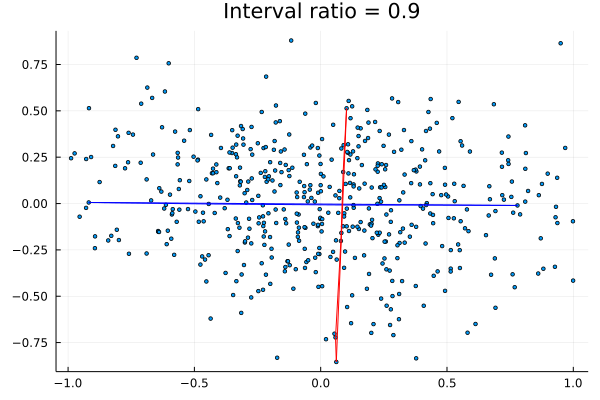

In [67]:
plotting_cycle(;pointcloud=pointcloud, cohomology=klein_vrips_normal,num = 2, timerate=0.9)

In [ ]:
staticpointcloud = staticalize(pointcloud)
distmat = distance_matrix(staticpointcloud, distance_in_klein_bottle)
klein_vrips_fill = Rips(distmat; threshold=nothing)
klein_vrips_co = ripserer(klein_vrips_fill; dim_max=2, reps=true)
vrips = ripserer(staticpointcloud;  dim_max=2)

3-element Vector{PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 133-element 1-dimensional PersistenceDiagram
 0-element 2-dimensional PersistenceDiagram

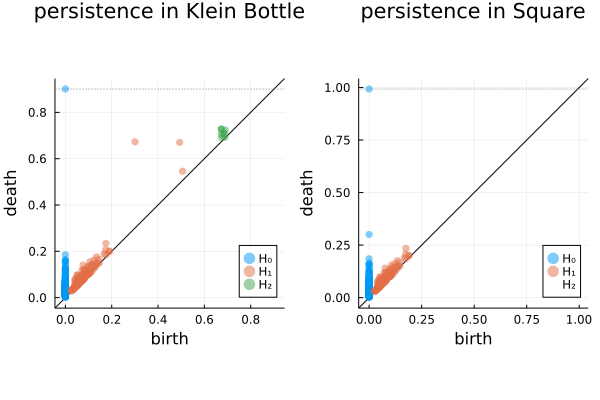

In [ ]:
plot(plot(klein_vrips_co; title="persistence in Klein Bottle"), plot(vrips; title="persistence in Square"))

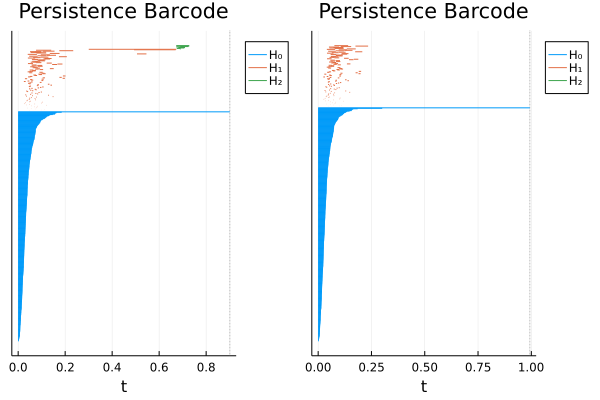

In [ ]:
plot(barcode(klein_vrips_co), barcode(vrips))

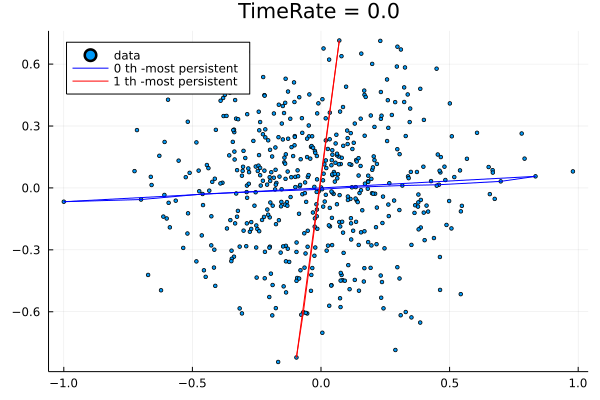

In [ ]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=klein_vrips_co, num = 2, timerate = 0.0, legend=:topleft)

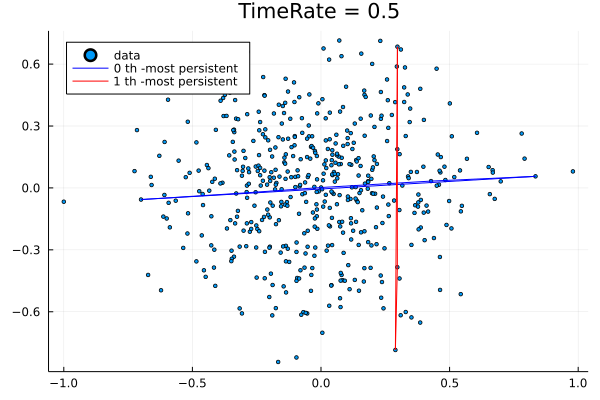

In [ ]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=klein_vrips_co,num = 2, timerate = 0.5, legend=:topleft)

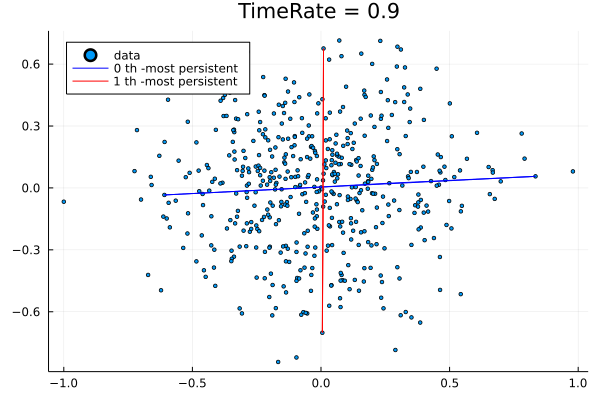

In [ ]:
plotting_cycle(;pointcloud=staticpointcloud, cohomology=klein_vrips_co,num= 2,timerate = 0.9, legend=:topleft)

In [ ]:
pointcloud = randn_poitns(;num_point=500, dim=1)

500×1 Matrix{Float64}:
 -0.1688410450989049
  0.066215650638807
  0.3563196924220104
  0.4816971361699847
  0.6259250014127756
  0.2574493693083758
 -0.2989571855066787
 -0.21071936591618898
 -0.23822022343098906
  0.010044218734459034
 -0.22157778407459738
  0.148628537025696
  0.19059305896695697
  ⋮
  0.19913191182061407
  0.14966929234578585
 -0.5730793351646071
  0.015852354562836186
  0.07970220089439871
  0.09565106126174451
  0.09145818576098415
 -0.14262055014153524
 -0.046031062609688526
  0.43413691437893887
  0.0350162125575115
 -0.17367967436919482

In [ ]:
#staticpointcloud = staticalize(Matrix(pointcloud_pca))
distmat = distance_matrix(pointcloud, Distance_in_Circle)

500×500 Matrix{Float64}:
 0.0          0.906246    1.98753    …  1.79788     0.714121    0.000462105
 0.906246     0.0         1.24932       1.67497     0.0191528   0.936553
 1.98753      1.24932     0.0           0.117169    1.43318     1.98229
 1.58505      1.86228     0.294572      0.0443183   1.94441     1.56012
 0.722421     1.93045     1.12287       0.642344    1.84125     0.693346
 1.89466      0.639094    0.186831   …  0.555482    0.827657    1.90782
 0.315985     1.66213     1.56064       1.10602     1.50348     0.294127
 0.0344192    1.16843     1.91259       1.61362     0.973209    0.026959
 0.093519     1.3354      1.8287        1.46872     1.14548     0.0811027
 0.567894     0.0616379   1.56869       1.8884      0.0122841   0.595506
 0.0543975    1.23524     1.88259    …  1.55836     1.04142     0.0449455
 1.41134      0.131097    0.737286      1.22126     0.244152    1.43886
 1.63468      0.290133    0.494894      0.959446    0.440918    1.65788
 ⋮                        

In [ ]:
circle_vrips_fill = Rips(distmat; threshold=nothing)
circle_vrips_co = ripserer(circle_vrips_fill; dim_max=2, reps=true)

3-element Vector{PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 1-element 1-dimensional PersistenceDiagram
 47-element 2-dimensional PersistenceDiagram

In [ ]:
projection_vrips_fill = Rips(distance_matrix(pointcloud, Distance_in_RealProjection); threshold=nothing)
projection_vrips_co = ripserer(projection_vrips_fill; dim_max=2, reps=true)

3-element Vector{PersistenceDiagram}:
 500-element 0-dimensional PersistenceDiagram
 1-element 1-dimensional PersistenceDiagram
 53-element 2-dimensional PersistenceDiagram

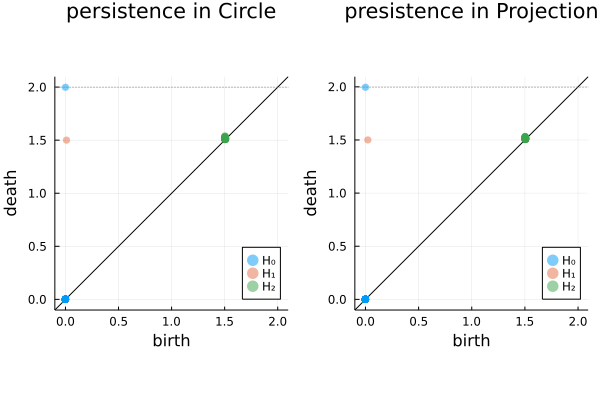

In [ ]:
plot(plot(circle_vrips_co; title="persistence in Circle"), plot(projection_vrips_co; title="presistence in Projection"))

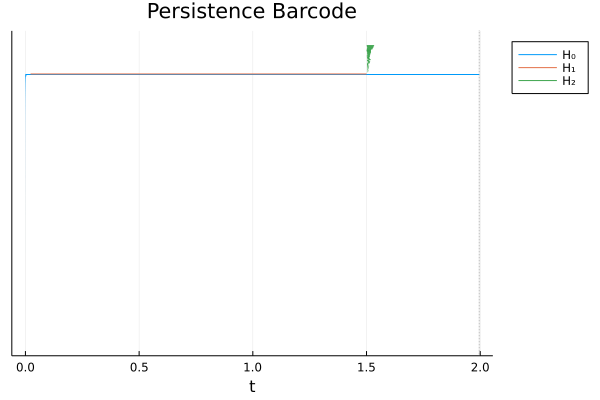

In [ ]:
barcode(projection_vrips_co)

In [71]:
function annulus(n, r1=1, r2=2, offset=(0, 0), normalize = true)
    result = Tuple{Float64,Float64}[]
    while length(result) < n
        point = 2 * r2 * rand(2) .- r2
        if r1 < norm(point) < r2
            push!(result, ((point[1] + offset[1])/r2, (point[2] + offset[2])/r2))
        end
    end
    return result
end

function ToVector(point::Tuple{Float64, Float64})::SPoint
    @sa.SVector[point[1], point[2]]
end

data = annulus(300)
randompoints = [ToVector(d) for d = data]

300-element Vector{SVector{2, Float64}}:
 [-0.1120430039374456, -0.6388751937060733]
 [0.4019492918893708, 0.4802142596128207]
 [0.22486725186594758, -0.7247001343192212]
 [-0.5514759186673632, 0.261449210754402]
 [0.7677729197974448, -0.010517958444063336]
 [-0.33654465608967055, 0.6583241109794034]
 [-0.5512263390411736, -0.19536452430606865]
 [-0.8906352812558065, -0.4351753961139124]
 [0.919425054282826, -0.3213080319179338]
 [-0.3774933896742041, 0.7458357387037049]
 [0.21315737107616206, -0.9733001916066648]
 [-0.8370616245306977, -0.5453988417001716]
 [0.47772044573105754, -0.2052316914038661]
 ⋮
 [0.30064166378328383, 0.7668203554066022]
 [0.646511752149153, 0.54105461941868]
 [0.8751909474854533, -0.32680415239487615]
 [0.4915344462411524, 0.40525651359433756]
 [0.18243778696117796, 0.957115556509573]
 [-0.4462089626541905, -0.8077554433753873]
 [0.27719831780092163, -0.834993831383279]
 [-0.36042466597010714, 0.35490023351777134]
 [-0.3390416425441649, -0.8562526402799324]
 [

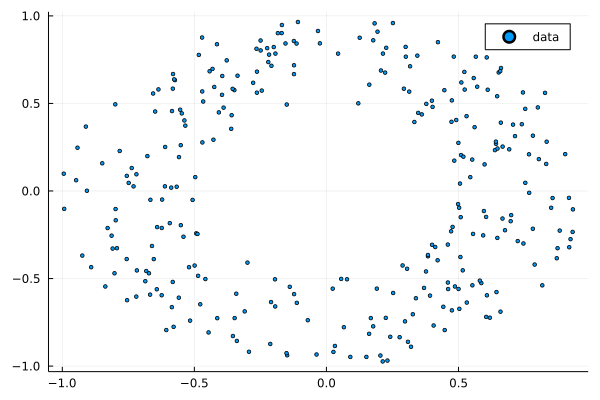

In [72]:
scatter(data; label="data", markersize=2)

In [73]:
vrips_kelin_co = CreateRipsPCohomology(;pointcloud = randompoints, distance = distance_in_klein_bottle)

3-element Vector{PersistenceDiagram}:
 300-element 0-dimensional PersistenceDiagram
 69-element 1-dimensional PersistenceDiagram
 38-element 2-dimensional PersistenceDiagram

In [74]:
distmat = distance_matrix(randompoints, Distance_in_Torus)

300×300 Matrix{Float64}:
 0.0       1.50442   1.28889   1.45542   …  1.23888   1.84327   1.34324
 1.50442   0.0       1.13057   0.920606     1.33448   0.916282  0.642546
 1.28889   1.13057   0.0       0.91598      1.88391   1.66649   0.581004
 1.45542   0.920606  0.91598   0.0          1.66454   1.38348   0.922049
 1.40138   1.91402   1.78523   1.59972      1.31605   1.62441   1.95767
 1.46038   1.27896   1.91529   1.60585   …  0.317072  0.859387  1.67777
 1.9661    1.22218   1.67924   1.40122      1.32765   0.484111  1.53214
 1.23874   1.18423   1.22384   1.69129      1.34618   1.37884   1.0146
 1.1964    1.63581   1.7784    1.96244      0.86259   1.40456   1.68504
 1.68696   1.38349   1.94503   1.59233      0.705568  0.729185  1.76941
 1.72077   1.60701   0.99695   1.34629   …  1.95926   1.57314   1.3314
 1.15061   0.971561  0.803122  1.36824      1.55303   1.491     0.5693
 1.93893   1.2271    1.73507   1.41243      1.23489   0.447445  1.57409
 ⋮                                     

In [75]:
vrips_torus_co = CreateRipsPCohomology(;pointcloud = randompoints, distance = Distance_in_Torus)

3-element Vector{PersistenceDiagram}:
 300-element 0-dimensional PersistenceDiagram
 91-element 1-dimensional PersistenceDiagram
 67-element 2-dimensional PersistenceDiagram

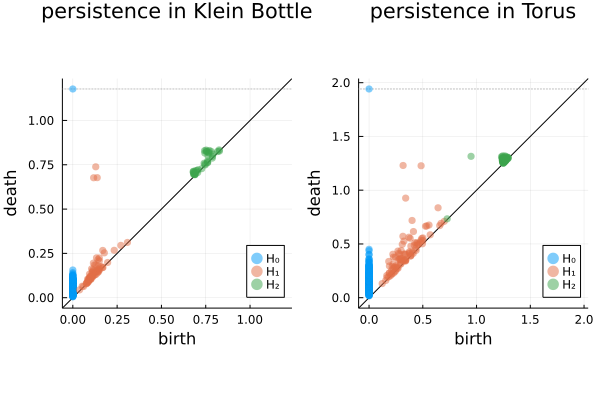

In [76]:
plot(plot(vrips_kelin_co; title="persistence in Klein Bottle"), plot(vrips_torus_co; title="persistence in Torus"))

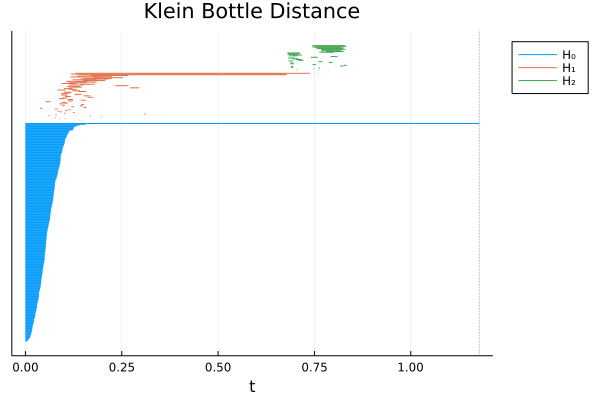

In [77]:
barcode(vrips_kelin_co, title ="Klein Bottle Distance")

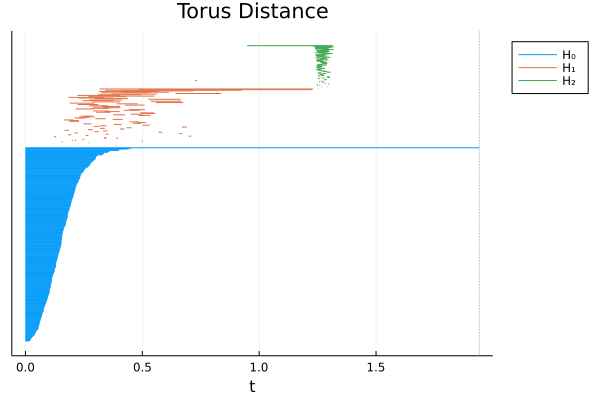

In [78]:
barcode(vrips_torus_co, title="Torus Distance")

In [ ]:
function plotting_cycle(;pointcloud::Vector{SPoint}, cohomology, num::Int64,timerate,legend=nothing)
    filtration = cohomology[2].filtration
    cycles =[]
    for i = 0:num-1
        persistent_co = cohomology[2][end - i]
        time = (death(persistent_co) - birth(persistent_co))*timerate + birth(persistent_co)
        reconstructed_at_time = reconstruct_cycle(filtration, persistent_co,time)
        push!(cycles, reconstructed_at_time)
        #println(cycles)
    end
    common_cycle = cycles[1]
    for cycle = cycles
        common_cycle = intersect(common_cycle, cycle)
    end
    x = [point[1] for point = pointcloud]
    y = [point[2] for point = pointcloud]
    scatter(x,y; label="data", markersize=2, legend = legend)
    i = 0
    for cycle = cycles
        if num > 1
            colorRate = 1 - i / (num - 1)
        else
            colorRate = 1
        end
        
        plot!(cycle, x, y; label="$i th -most persistent", color=RGBA(1- colorRate, 0, colorRate))
        i +=1
    end
    if !isempty(common_cycle)
        plot!(common_cycle, x, y; label="intersect", color="green")
    end
    plot!(title="TimeRate = $timerate")
end

# x = 0  y = 1, x = n- 1 y = 0
# y - 1= - 1/ (n - 1) * x

plotting_cycle (generic function with 1 method)

### Klein bottle 上でのアニュラス

Simplex{1, Float64, Int64}[+Simplex{1}((249, 227), 0.12933931296212964), +Simplex{1}((249, 122), 0.1148584436104688), +Simplex{1}((162, 122), 0.09025446957448925), +Simplex{1}((167, 162), 0.08516270984859112), +Simplex{1}((167, 4), 0.05991017301454894), +Simplex{1}((45, 4), 0.11311343451114811), +Simplex{1}((148, 45), 0.07119056561326438), +Simplex{1}((248, 148), 0.10567017451029631), +Simplex{1}((248, 66), 0.09284894511224379), +Simplex{1}((66, 6), 0.10917713069920003), +Simplex{1}((138, 6), 0.07718896514837044), +Simplex{1}((208, 138), 0.10740965528392296), +Simplex{1}((208, 101), 0.04673572200873333), +Simplex{1}((101, 100), 0.08535124620523031), +Simplex{1}((146, 100), 0.08818102839794781), +Simplex{1}((230, 146), 0.1233269612760389), +Simplex{1}((256, 230), 0.0850703048456429), +Simplex{1}((256, 180), 0.11224728906077085), +Simplex{1}((212, 180), 0.11450402573138369), +Simplex{1}((212, 3), 0.056734817716137996), +Simplex{1}((234, 3), 0.10432771222326857), +Simplex{1}((272, 234), 0

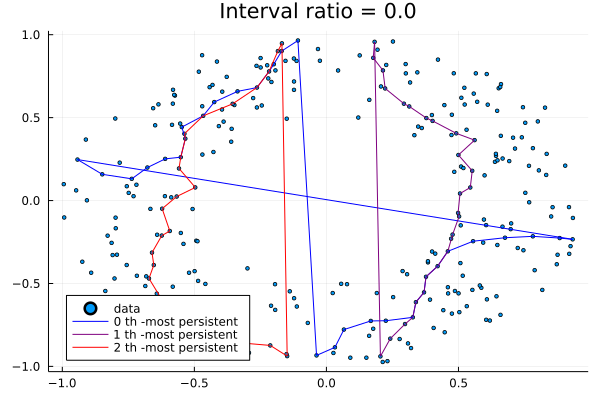

In [79]:
plotting_cycle(;pointcloud=randompoints, cohomology=vrips_kelin_co,num = 3, timerate = 0.0, legend=:bottomleft)

### Torus 上でのアニュラス

Simplex{1, Float64, Int64}[+Simplex{1}((237, 162), 0.31678528433694403), +Simplex{1}((237, 117), 0.1475616960463572), +Simplex{1}((117, 4), 0.20379702886493953), +Simplex{1}((184, 4), 0.2777297825698111), +Simplex{1}((184, 45), 0.24613279611152306), +Simplex{1}((225, 45), 0.13438375516465778), +Simplex{1}((225, 202), 0.3116492455402026), +Simplex{1}((202, 24), 0.24499784727344573), +Simplex{1}((67, 24), 0.26489965321697395), +Simplex{1}((67, 18), 0.26473145818267846), +Simplex{1}((48, 18), 0.2557313606068738), +Simplex{1}((175, 48), 0.30102864489505526), +Simplex{1}((246, 175), 0.08792698547904558), +Simplex{1}((246, 49), 0.2669037015865504), +Simplex{1}((78, 49), 0.21363860316687425), +Simplex{1}((196, 78), 0.21974869842760775), +Simplex{1}((196, 15), 0.2831475448903736), +Simplex{1}((293, 15), 0.2792156560730569), +Simplex{1}((293, 179), 0.3062440754851935), +Simplex{1}((242, 179), 0.30710480967901127), +Simplex{1}((242, 23), 0.3081744124880461), +Simplex{1}((110, 23), 0.228970902697

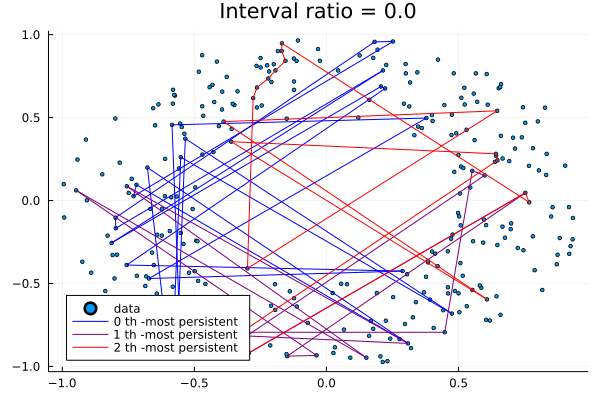

In [81]:
plotting_cycle(;pointcloud=randompoints, cohomology=vrips_torus_co,num = 3, timerate = 0.0, legend=:bottomleft)

In [35]:
Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [36]:
using Distributions

### 混合分布
$$f_{mix}(x; \Theta, \pi) = \sum_{k = 1}^{K} \pi_k f(x;\theta_k)$$

$f( \cdot ; \theta) = \mathcal{N}(\mathbb{\mu}, \mathbb{{\Sigma}})$

In [ ]:
d = Normal()

Normal{Float64}(μ=0.0, σ=1.0)